# Use DQN to Play MoutainCar-v0

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import itertools
import copy

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(0)

logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('MountainCar-v0')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

22:49:45 [INFO] env: <MountainCarEnv<MountainCar-v0>>
22:49:45 [INFO] action_space: Discrete(3)
22:49:45 [INFO] observation_space: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
22:49:45 [INFO] reward_range: (-inf, inf)
22:49:45 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 30}
22:49:45 [INFO] _max_episode_steps: 200
22:49:45 [INFO] _elapsed_steps: None
22:49:45 [INFO] id: MountainCar-v0
22:49:45 [INFO] entry_point: gym.envs.classic_control:MountainCarEnv
22:49:45 [INFO] reward_threshold: -110.0
22:49:45 [INFO] nondeterministic: False
22:49:45 [INFO] max_episode_steps: 200
22:49:45 [INFO] _kwargs: {}
22:49:45 [INFO] _env_name: MountainCar


In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward', 'next_state', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = np.asarray(args, dtype=object)
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class DQNAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99

        self.replayer = DQNReplayer(10000)

        self.evaluate_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[64, 64], output_size=self.action_n)
        self.optimizer = optim.Adam(self.evaluate_net.parameters(), lr=0.001)
        self.loss = nn.MSELoss()

    def build_net(self, input_size, hidden_sizes, output_size):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        model = nn.Sequential(*layers)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []
            self.target_net = copy.deepcopy(self.evaluate_net)

    def step(self, observation, reward, done):
        if self.mode == 'train' and np.random.rand() < 0.001:
            # epsilon-greedy policy in train mode
            action = np.random.randint(self.action_n)
        else:
            state_tensor = torch.as_tensor(observation,
                    dtype=torch.float).squeeze(0)
            q_tensor = self.evaluate_net(state_tensor)
            action_tensor = torch.argmax(q_tensor)
            action = action_tensor.item()
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                state, _, _, act, next_state, reward, done, _ = \
                        self.trajectory[-8:]
                self.replayer.store(state, act, reward, next_state, done)
            if self.replayer.count >= self.replayer.capacity * 0.95:
                    # skip first few episodes for speed
                self.learn()
        return action

    def close(self):
        pass

    def learn(self):
        # replay
        states, actions, rewards, next_states, dones = \
                self.replayer.sample(1024) # replay transitions
        state_tensor = torch.as_tensor(states, dtype=torch.float)
        action_tensor = torch.as_tensor(actions, dtype=torch.long)
        reward_tensor = torch.as_tensor(rewards, dtype=torch.float)
        next_state_tensor = torch.as_tensor(next_states, dtype=torch.float)
        done_tensor = torch.as_tensor(dones, dtype=torch.float)

        # train
        next_q_tensor = self.target_net(next_state_tensor)
        next_max_q_tensor, _ = next_q_tensor.max(axis=-1)
        target_tensor = reward_tensor + self.gamma * (1. - done_tensor) * \
                next_max_q_tensor
        pred_tensor = self.evaluate_net(state_tensor)
        q_tensor = pred_tensor.gather(1, action_tensor.unsqueeze(1)).squeeze(1)
        loss_tensor = self.loss(target_tensor, q_tensor)
        self.optimizer.zero_grad()
        loss_tensor.backward()
        self.optimizer.step()


agent = DQNAgent(env)

22:49:46 [INFO] ==== train ====
22:49:46 [DEBUG] train episode 0: reward = -200.00, steps = 200
22:49:46 [DEBUG] train episode 1: reward = -200.00, steps = 200
22:49:46 [DEBUG] train episode 2: reward = -200.00, steps = 200
22:49:46 [DEBUG] train episode 3: reward = -200.00, steps = 200
22:49:47 [DEBUG] train episode 4: reward = -200.00, steps = 200
22:49:47 [DEBUG] train episode 5: reward = -200.00, steps = 200
22:49:47 [DEBUG] train episode 6: reward = -200.00, steps = 200
22:49:47 [DEBUG] train episode 7: reward = -200.00, steps = 200
22:49:47 [DEBUG] train episode 8: reward = -200.00, steps = 200
22:49:48 [DEBUG] train episode 9: reward = -200.00, steps = 200
22:49:48 [DEBUG] train episode 10: reward = -200.00, steps = 200
22:49:48 [DEBUG] train episode 11: reward = -200.00, steps = 200
22:49:48 [DEBUG] train episode 12: reward = -200.00, steps = 200
22:49:48 [DEBUG] train episode 13: reward = -200.00, steps = 200
22:49:49 [DEBUG] train episode 14: reward = -200.00, steps = 200
22:

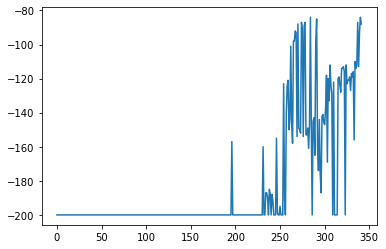

In [5]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -110:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [6]:
env.close()